In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt

def dataGen():
    N = 100 # number of points per class
    d0 = 2 # dimensionality
    C = 3 # number of classes
    X = np.zeros((d0, N*C)) # data matrix (each row = single example)
    y = np.zeros(N*C, dtype='uint8') # class labels

    for j in range(C):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T
      y[ix] = j

    # lets visualize the data:
    plt.plot(X[0, :N], X[1, :N], 'bs', markersize = 7);
    plt.plot(X[0, N:2*N], X[1, N:2*N], 'ro', markersize = 7);
    plt.plot(X[0, 2*N:], X[1, 2*N:], 'g^', markersize = 7);

    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    plt.show()

    return {"X": X, "y": y}


In [25]:
import numpy as np

def mLPFsoftmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

## One-hot coding
from scipy import sparse
def convert_labels(y, C = 3):
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

# cost or loss function
l = 0.01
def mLPFcost(Y, Yhat, Wl, W):
    w = []
    for i in W:
        w.append(np.square(i).sum())
    wl = np.square(Wl).sum()
    R = sum(w) + wl
    return (-np.sum(Y*np.log(Yhat))/Y.shape[1])+(l/(2*Y.shape[1]))*R


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def mLPTraining(X, y, layerCount, nodeCounts):
    d0 = 2
    # LayerCount là hidden layer count. Ta gọi dl là d của lớp cuối (output layer) 
    dl = C = 3
    # Tạo một danh sách w, sẽ kích thước là layerCount
    W = []
    b = []

    i = 0
    while i <= layerCount - 1:
        preNodeCount = d0
        if i != 0:
            preNodeCount = nodeCounts[i - 1]
        W.append(0.01*np.random.randn(preNodeCount, nodeCounts[i]))
        b.append(np.zeros((nodeCounts[i], 1)))
        i = i + 1

    Wl = 0.01*np.random.randn(nodeCounts[layerCount - 1], dl)
    bl = np.zeros((dl, 1))

    Y = convert_labels(y, C)

    N = X.shape[1]
    eta = 1 # Tham chiếu learning rate
    for j in range(1000):
        ## Feedforward
        Z = []
        A = []
        
        i = 0
        while i < layerCount:
            preA = X
            if i != 0:
                preA = A[i - 1]
            Z.append(np.dot(W[i].T, preA) + b[i])
            A.append(np.maximum(Z[i], 0))
            i = i + 1

        Zl = np.dot(Wl.T, A[layerCount - 1]) + bl

        Yhat = mLPFsoftmax(Zl) #Softmax

        # In loss sau mỗi 1000 vòng lặp 
        if j %10 == 0:
            # average cross-entropy loss
            loss = mLPFcost(Y, Yhat, Wl, W)
            print("iter %d, loss: %f" %(j, loss))

        # backpropagation
        El = (Yhat - Y )/N
        dWl = np.dot(A[layerCount - 1], El.T)
        dbl = np.sum(El, axis = 1, keepdims = True)

        EPre = El
        dW = []
        db = []

        i = layerCount - 1
        while i >= 0:
            Wt = Wl
            if i < layerCount - 1:
                Wt = W[i + 1]
            # EPre là E tính trước đó, EPre cập nhật sau mỗi vòng lặp 
            EPre = np.dot(Wt, EPre)
            EPre[Z[i] <= 0] == 0
            if i != 0:
                dW.append(np.dot(A[i - 1], EPre.T))
            else:
                dW.append(np.dot(X, EPre.T))
            db.append(np.sum(EPre, axis = 1, keepdims = True))
            i = i - 1

        # Đảo ngược mảng dW, do vòng lặp trước đi lùi về 0
        dW.reverse()
        db.reverse()

        # Cập nhật gradient Descent

        for i in range(0, layerCount - 1):
            W[i] += -eta*dW[i]
            b[i] += -eta*db[i]
        
        Wl += -eta*dWl
        bl += -eta*dbl

    # Apre là A trước đó, tại i - 1 hoặc A1 (i == 0)
    Apre = X

    for i in range(0, layerCount - 1):
        Z[i] = np.dot(W[i].T, Apre) + b[i]
        A[i] = np.maximum(Z[i], 0)
        Apre = A[i]

    Zl = np.dot(Wl.T, A[layerCount - 1]) + bl

    predicted_class = np.argmax(Zl, axis=0)
    acc = (100*np.mean(predicted_class == y))
    print('training accuracy: %.2f %%' % acc)

    # Trực quan hóa kết quả phân loại 
    xm = np.arange(-1.5, 1.5, 0.025)
    xlen = len(xm)
    ym = np.arange(-1.5, 1.5, 0.025)
    ylen = len(ym)
    xx, yy = np.meshgrid(xm, ym)

    print(np.ones((1, xx.size)).shape)
    xx1 = xx.ravel().reshape(1, xx.size)
    yy1 = yy.ravel().reshape(1, yy.size)

    X0 = np.vstack((xx1, yy1))

    Z1 = np.dot(W[0].T, X0) + b[0] 
    A1 = np.maximum(Z1, 0)
    Z2 = np.dot(W[1].T, A1) + b[1]
    # predicted class 
    Zm = np.argmax(Z2, axis=0)

    Zm = Zm.reshape(xx.shape)
    CS = plt.contourf(xx, yy, Zm, 200, cmap='jet', alpha = .1)

    # X = X.T
    N = 100
    plt.plot(X[0, :N], X[1, :N], 'bs', markersize = 7);
    plt.plot(X[0, N:2*N], X[1, N:2*N], 'g^', markersize = 7);
    plt.plot(X[0, 2*N:], X[1, 2*N:], 'ro', markersize = 7);

    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xticks(())
    plt.yticks(())
    plt.title('#hidden units = %d, accuracy = %.2f %%' %(nodeCounts[0], acc))
    plt.show()


In [29]:
def userInput():
    # Đợi người dùng nhập số lớp 
    layerCountStr = input("Vui long nhap so lop: ")

    try: 
        # Chuyển chuỗi nhập sang kiểu số nguyên  
        layerCount = int(layerCountStr) 
        # Báo lỗi khi không phải số tự nhiên khác 0
        if layerCount != float(layerCountStr) or layerCount <= 0:
            raise Exception()
    except:
        print("So khong hop le!")
        # Lặp lại việc hỏi số lớp (lặp lại hàm) 
        return userInput()

    listNodeCounts = []

    i = 0
    # Lặp lại từ i -> layerCount 
    while i < layerCount:
        nodeCountStr = input("Nhap so node o layer %d: " % i)

        try:
            nodeCount = int(nodeCountStr) 
            # Báo lỗi khi không phải số tự nhiên khác 0
            if nodeCount != float(nodeCountStr) or nodeCount <= 0:
                raise Exception()
            # Thêm vào danh sách 
            listNodeCounts.append(nodeCount)
        except:
            print("So node khong hop le!")
            continue

        i = i + 1

    # Trả về một object kiểu Dict. Lấy dữ liệu như từ điển, như object["layerCount"]
    return {"layerCount": layerCount, "nodeCounts": listNodeCounts}


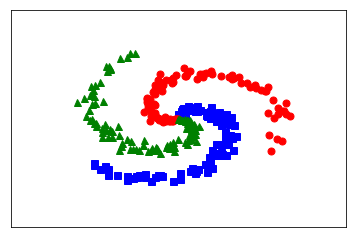

Vui long nhap so lop:  3
Nhap so node o layer 0:  2
Nhap so node o layer 1:  4
Nhap so node o layer 2:  8


iter 0, loss: 1.098612
iter 10, loss: 1.098612
iter 20, loss: 1.098612
iter 30, loss: 1.098612
iter 40, loss: 1.098612
iter 50, loss: 1.098612
iter 60, loss: 1.098612
iter 70, loss: 1.098612
iter 80, loss: 1.098612
iter 90, loss: 1.098612
iter 100, loss: 1.098612
iter 110, loss: 1.098612
iter 120, loss: 1.098612
iter 130, loss: 1.098612
iter 140, loss: 1.098612
iter 150, loss: 1.098612
iter 160, loss: 1.098612
iter 170, loss: 1.098612
iter 180, loss: 1.098612
iter 190, loss: 1.098612
iter 200, loss: 1.098612
iter 210, loss: 1.098612
iter 220, loss: 1.098612
iter 230, loss: 1.098612
iter 240, loss: 1.098612
iter 250, loss: 1.098612
iter 260, loss: 1.098612
iter 270, loss: 1.098612
iter 280, loss: 1.098612
iter 290, loss: 1.098612
iter 300, loss: 1.098612
iter 310, loss: 1.098612
iter 320, loss: 1.098612
iter 330, loss: 1.098612
iter 340, loss: 1.098612
iter 350, loss: 1.098612
iter 360, loss: 1.098612
iter 370, loss: 1.098612
iter 380, loss: 1.098612
iter 390, loss: 1.098612
iter 400, l

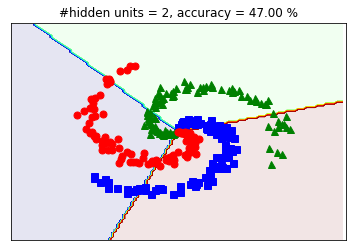

In [32]:
data = dataGen()
networkConfig = userInput()
mLPTraining(data["X"], data["y"], networkConfig["layerCount"], networkConfig["nodeCounts"])